<h1>PSI Numerical Methods 2026 - Homework 3
<br>2026-01-21
<br>Dustin Lang, Perimeter Institute
</h1>

In this notebook, there are places in the code where I have left blank places and you have to complete the code.

Please feel free to delete any of the text in this notebook, and add any code or plots you use to explore the method or solve the "extension" questions below.

You will hand in your homework using `git` and GitHub, by pushing your final notebook to your GitHub repository.

<h2>Using Markov Chain Monte Carlo to infer the parameters of a simple model
</h2>

In [1]:
# Import some python packages we'll use
import pylab as plt
import numpy as np
import scipy.stats
import scipy.optimize

In [2]:
# Example data set from  arxiv:1008.4686, table 1 (https://arxiv.org/abs/1008.4686)
# You can also refer to that paper for more background, equations, etc.
alldata = np.array([[201,592,61],[244,401,25],[47 ,583,38],[287,402,15],[203,495,21],[58 ,173,15],[210,479,27],
                   [202,504,14],[198,510,30],[158,416,16],[165,393,14],[201,442,25],[157,317,52],[131,311,16],
                   [166,400,34],[160,337,31],[186,423,42],[125,334,26],[218,533,16],[146,344,22],]).astype(float)
# The first 5 data points are outliers; for the first part we'll just use the "good" data points
x    = alldata[5:,0]
y    = alldata[5:,1]
# this is the standard deviation (uncertainty) on the y measurements, also known as \sigma_i
yerr = alldata[5:,2]
# Note that x, y, and yerr are *vectors* (numpy arrays)

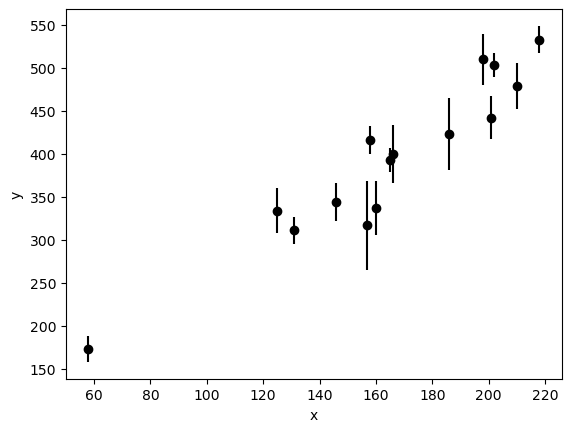

In [3]:
# To start, let's have a look at our data set.
plt.errorbar(x, y, yerr=yerr, fmt='o', color='k');
plt.xlabel('x'); plt.ylabel('y');

For this lab, we are going to imagine that there is some physical reason to believe there is a *linear* relationship between the quantities $x$ and $y$, so our *generative model* of the process is that there is a "real" or "predicted" value $y_{\textrm{pred}}$ given by $y_{\textrm{pred}} = b + m x$, for some parameters $b$ and $m$ that we will try to infer.  Our *measurements* $y$ are noisy measurements of $y_{\textrm{pred}}$, with additive Gaussian noise with known variance, $\sigma_i$ for data point $i$.  ($\sigma$ is called `yerr`, short for `y error`, in this notebook.)  This is a strong assumption about our data-collection method.

With those assumptions, we can write down the *likelihood* for a single measurement $y_i$ given its corresponding $x_i$ and $\sigma_i$, and straight-line model parameters $b$ and $m$:

$y_{\textrm{pred},i} = b + m x_i$

And the Gaussian probability distribution function (the likelihood) for $y_i$ is then:

  $p(y_i | m, b) = \frac{1}{\sqrt{2 \pi} \sigma_i} \exp(-\frac{(y - y_{\textrm{pred},i})^2}{2 \sigma_i^2})$


We are making a number of simplifying assumptions here:

* there are no uncertainties on the $x$ values
* there are additive Gaussian measurement uncertainties on the $y$ values with known standard deviations $\sigma$
* the data points are statistically independent

Since we are assuming the $x$ and $\sigma$ values are perfectly known, we will treat them as *constants* rather than *data* in the probability equations.

In practice, it is usually preferable to work in log-probabilities rather than
linear probabilities, because the probability values can be very small, and if we're not careful we can hit a numerical issue called *underflow*, where the numbers become so small that they can't be represented in standard floating-point numerical representation.

If the data points are statistically independent, then the likelihood of the whole collection of data points $y = \{ y_i \}$ is the *product* of their individual likelihoods:

$p(y | m,b) = \prod_i \frac{1}{\sqrt{2 \pi} \sigma_i} \exp(-\frac{(y - y_{\textrm{pred},i})^2}{2 \sigma_i^2})$

and taking the log,

$\log p(y | m,b) = \sum_i \log(\frac{1}{\sqrt{2 \pi} \sigma_i}) -\frac{(y - y_{\textrm{pred},i})^2}{2 \sigma_i^2}$

The first thing we will do is implement that log-likelihood function!


In [4]:
def log_likelihood_one(params, x, y, yerr):
    '''This function computes the log-likelihood of a data set with coordinates
    (x_i,y_i) and Gaussian uncertainties on y_i of yerr_i (aka sigma_i)

    The model is a straight line, so the model's predicted y values are
        y_pred_i = b + m x_i.

    params = (b,m) are the parameters (scalars)
    x,y,yerr are arrays (aka vectors)

    Return value is a scalar log-likelihood.
    '''
    # unpack the parameters
    b,m = params
    # compute the vector y_pred, the model predictions for the y measurements
    y_pred = b + m * x
    # compute the log-likelihoods for the individual data points
    # (the quantity inside the sum in the text above)
    
    ### FILL IN CODE HERE!  Implement the log-likelihood function from the text above!
    loglikes = np.log(1/(np.sqrt(2*np.pi)*yerr)) + -0.5 * (y-y_pred)**2 / (yerr)**2
    
    # the log-likelihood for the whole vector of measurements is the sum of individual log-likelihoods
    loglike = np.sum(loglikes)
    return loglike

<h2>Maximum likelihood</h2>

Before we start experimenting Markov Chain Monte Carlo, let's use a
stock optimizer routine from the *scipy* package.  The optimizer will allow us to find the *maximum likelihood* paramaters $b$ and $m$.

Since the optimizer wants to *minimize*
a function but we want to *maximize* the log-likelihood, we need to add a
negative sign...

In [5]:
def neg_ll_one(params, x, y, yerr):
    return -log_likelihood_one(params, x, y, yerr)

In [6]:
# The optimizer we're using here requires an initial guess.  This log-likelihood happens
# to be pretty simple, so we don't need to work very hard to give it a good initial guess!
initial_params = [0., 0.]
# The "args" parameter here gets passed to the neg_ll_one function (after the parameters)
R = scipy.optimize.minimize(neg_ll_one, initial_params, args=(x, y, yerr))
R

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 70.29347391851827
        x: [ 3.485e+01  2.233e+00]
      nit: 5
      jac: [ 9.537e-07  7.629e-06]
 hess_inv: [[ 3.394e+02 -1.949e+00]
            [-1.949e+00  1.217e-02]]
     nfev: 27
     njev: 9

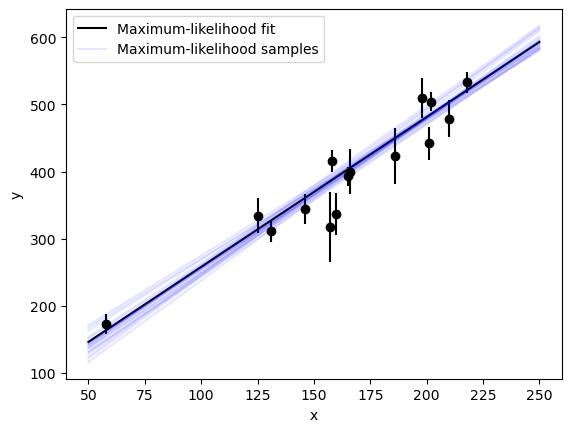

In [7]:
# The optimizer gives us the parameters that maximize the log-likelihood, along with an estimate of the uncertainties.
plt.errorbar(x, y, yerr=yerr, fmt='o', color='k');
# These are the maximum-likelihood values from the optimizer
b_ml,m_ml = R.x
xx = np.linspace(50, 250, 50)
plt.plot(xx, b_ml + m_ml * xx, 'k-', label='Maximum-likelihood fit')
plt.xlabel('x'); plt.ylabel('y')
# Draw a sampling of B,M parameter values that are consistent with the fit,
# using the estimated inverse-Hessian matrix (parameter covariance)
# (don't worry about understanding this function)
BM = scipy.stats.multivariate_normal.rvs(mean=R.x, cov=R.hess_inv, size=20)
b,m = BM[0]
plt.plot(xx, b + xx*m, 'b-', alpha=0.1, label='Maximum-likelihood samples')
for b,m in BM[1:]:
    plt.plot(xx, b + xx*m, 'b-', alpha=0.1)
plt.legend();

If you got your log-likelihood function right, your plot should look like my plot!

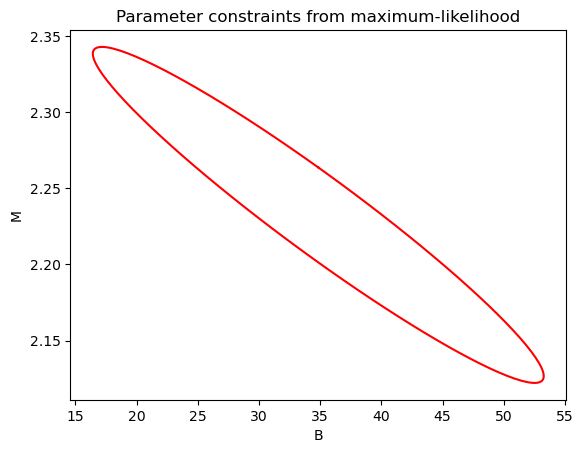

In [8]:
# You can also plot the ellipse showing the constraints in B,M space by manipulating hess_inv:
# (don't worry about understading this math!)
U,s,V = np.linalg.svd(R.hess_inv)
S = np.dot(U, np.diag(np.sqrt(s)))
th = np.linspace(0,2.*np.pi,200)
xy = np.vstack((np.sin(th), np.cos(th)))
dbm = np.dot(S, xy).T
ellipse_b = R.x[0] + dbm[:,0]
ellipse_m = R.x[1] + dbm[:,1]
plt.plot(ellipse_b, ellipse_m, 'r-')
plt.xlabel('B')
plt.ylabel('M')
plt.title('Parameter constraints from maximum-likelihood');

<h2>Markov Chain Monte Carlo</h2>

Next, let's implement the Markov Chain Monte Carlo algorithm.

The MCMC algorithm moves a "particle" or "sample" or "walker" randomly around the particle space, by first proposing a move, and then using the relative likelihoods of the current and proposed positions to decide whether to accept or reject the move.

In [64]:
def mcmc(logprob_func, logprob_args,
         propose_func, propose_args,
         initial_pos, nsteps):
    '''
    MCMC: Markov Chain Monte Carlo.  Draw samples from the *logprob_func* probability distribution,
    using proposed moves generated by the function *propose_func*.

    * logprob_func: a function that returns the log-probability at a given value of parameters.
               It will get called like this:
        lnp = logprob_func(params, logprob_args)
    * logprob_args: extra arguments to pass to logprob_func.
    * propose_func: a function that proposes to jump to a new point in parameter space.
               It will get called like this:
        p_new = propose_func(p, propose_args)
    * propose_args: extra arguments to pass to propose_func.
    * initial_pos: initial position in parameter space (list/array)
    * nsteps: integer number of MCMC steps to take
    
    Returns  (chain, faccept)
    * chain: size Nsteps x P, MCMC samples
    * faccept: float: fraction of proposed jumps that were accepted
    '''  
    p = initial_pos
    logprob = logprob_func(p, logprob_args)
    chain = []
    naccept = 0
    for i in range(nsteps):
        # propose a new position in parameter space
        ### FILL IN CODE HERE -- propose a jump to a new place in param space
        p_new = propose_func(p, propose_args)
        # compute probability at new position
        ### FILL IN CODE HERE
        logprob_new = logprob_func(p_new, logprob_args)
        # decide whether to jump to the new position
        #### FILL IN CODE HERE!!!
        diff = logprob_new - logprob
        if np.exp(diff) > np.random.uniform():
            p = p_new
            logprob = logprob_new
            naccept += 1
        # save the position
        chain.append(p)
    return np.array(chain), naccept/nsteps

Note that in the `mcmc` algorithm as written here, we're _assuming_ the proposal distribution is symmetric -- the probability of jumping from $x$ to $x'$ equals the probability of jumping from $x'$ back to $x$.

We'll use a Gaussian (without covariance between the parameters) for our proposal distribution:

In [65]:
def propose_gaussian(p, stdevs):
    '''
    A Gaussian proposal distribution for mcmc.
    *p*: the point in parameter space to jump from
    *stdevs*: standard deviations for each dimension in the parameter space.
    '''
    return np.random.normal(loc=p, scale=stdevs)

Now, we defined our log-likelihood function above, but when using MCMC for Bayesian inference, we need to pass it a log-*posterior* function.  That is,
we must include the log-prior for the parameters.  It is very common to see "uninformative" or "flat" priors used; in fact, it's not uncommon to see the log-prior just set to zero, as below, which is, statistically speaking, a naughty thing to do, since that prior definitely isn't a proper probability distribution -- it isn't even bounded!  But, it *feels* like we haven't imposed our *subjective* prior beliefs on the inference, which is why people often do it.  But you can't avoid subjectivity---if you change the parameterization, for example, a flat prior becomes non-flat!

In [66]:
def log_posterior_one(params, args):
    (x, y, yerr) = args
    loglike = log_likelihood_one(params, x, y, yerr)
    # Improper, flat priors on params!
    logprior = 0.
    return loglike + logprior

In [67]:
# initial B,M
initial_pos = [0., 1.0]
# proposal distribution: jump sizes for B,M
jump_sizes = [.1, 0.01]
# Run MCMC!
chain,accept = mcmc(log_posterior_one, (x,y,yerr),
                    propose_gaussian, jump_sizes,
                    initial_pos, 100000)
print("Fraction of moves accepted:", accept)
chain.shape

Fraction of moves accepted: 0.89682


(100000, 2)

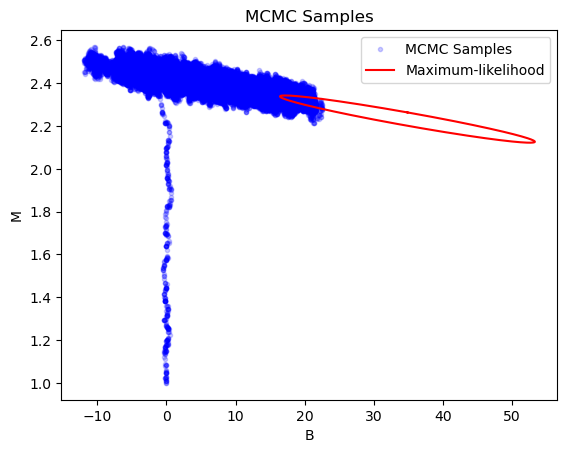

In [68]:
# Plot the parameter values in the chain!
plt.plot(chain[:,0], chain[:,1], 'b.', alpha=0.2, label='MCMC Samples');
plt.xlabel('B')
plt.ylabel('M')
plt.title('MCMC Samples')
# Also plot up the elliptical constraint we got from the optimizer.
plt.plot(ellipse_b, ellipse_m, 'r-', label='Maximum-likelihood')
plt.legend();

Try re-running the MCMC cell above and re-plotting the results.  Do the results look the same every time?  Does that suggest anything to you about whether the chain has *converged* after the number of steps we have taken?

Try increasing the number of steps -- do the results look better?  How long are you willing to wait?

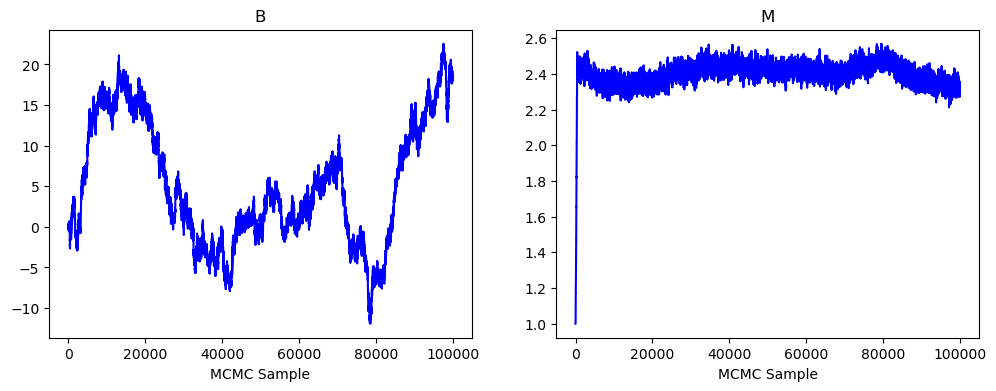

In [69]:
# Plot the MCMC chains with respect to sample number
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(chain[:,0], 'b-')
plt.xlabel('MCMC Sample')
plt.title('B')
plt.subplot(1,2,2)
plt.title('M')
plt.xlabel('MCMC Sample')
plt.plot(chain[:,1], 'b-');

Looking at these plots of how the "particle" moves through the $B$,$M$ parameter space, what do you see?  How often does it traverse the whole space?  Do you think the step sizes are too big or too small?

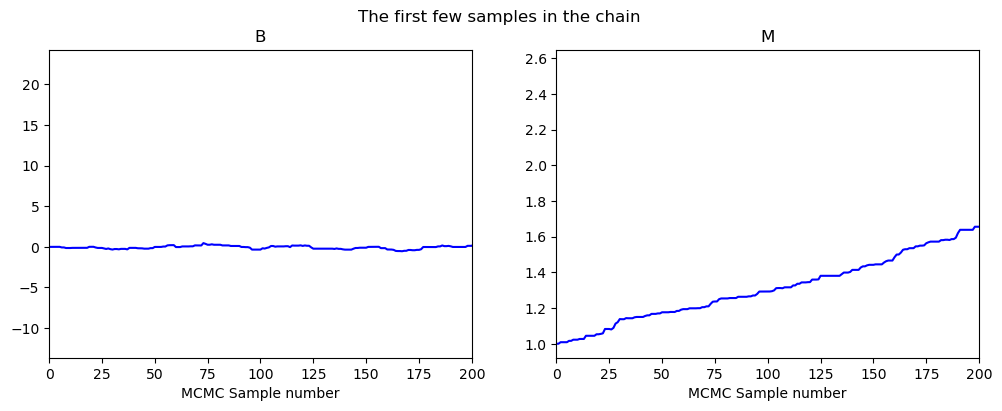

In [70]:
# Zoom in on the beginning of the chain to see the "burn-in", and repeated values
plt.figure(figsize=(12,4))
nstart = 200
plt.subplot(1,2,1)
plt.plot(chain[:,0], 'b-')
plt.xlim(0,nstart)
plt.title('B')
plt.xlabel('MCMC Sample number')
plt.subplot(1,2,2)
plt.title('M')
plt.xlabel('MCMC Sample number')
plt.plot(chain[:,1], 'b-');
plt.xlim(0,nstart);
plt.suptitle('The first few samples in the chain');

In the plots above, observe that our MCMC algorithm is moving toward the "core" of the probability mass.  Also observe that there are horizontal segments in the plots --- where we have proposed a number of moves that have been rejected, so that there are repeated `B,M` values in our MCMC chain.


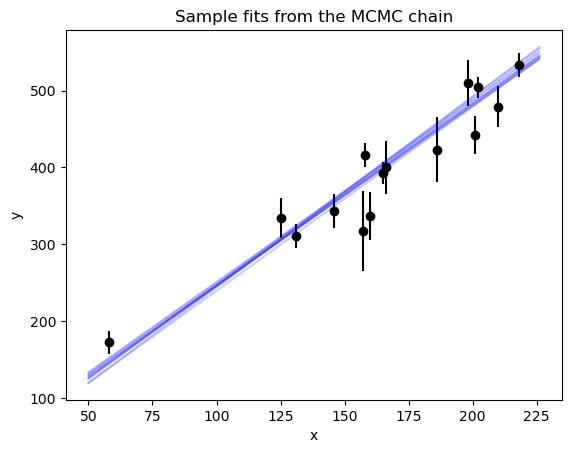

In [71]:
# Let's plot the models for a few randomly drawn MCMC samples.
plt.errorbar(x, y, yerr=yerr, fmt='o', color='k');
plt.xlabel('x'); plt.ylabel('y')
ax = plt.axis()

# Drop this many samples for "burn-in"
burn = 1000
# Draw some random entries from the chain
I = np.random.randint(burn, high=len(chain), size=10)
xx = np.array(ax[:2])
for b,m in chain[I]:
    plt.plot(xx, b + m*xx, 'b-', alpha=0.2)
plt.title('Sample fits from the MCMC chain');

Another thing we can do is histogram the $B$ and $M$ values.  In fact, let's make a "corner plot" where we also show the *marginal* distributions.  To do this, we'll use an extra python package, `corner`.

In [56]:
# Install the "corner" python package by Dan Foreman-Mackey;
# https://github.com/dfm/corner.py
! pip install corner

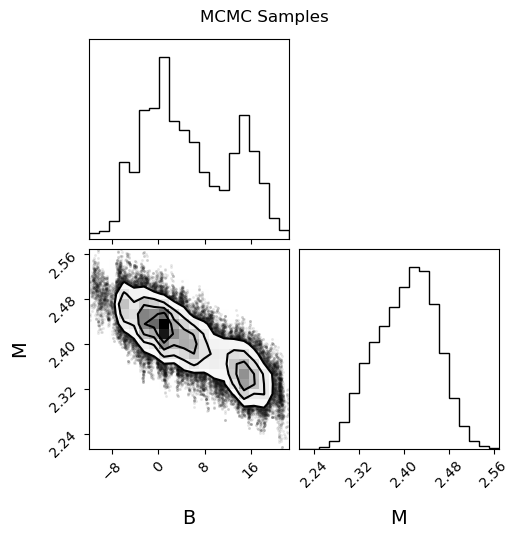

In [72]:
import corner
# In the plots above, we saw that there is a "burn-in" time where the sampler is searching for the core of the probability distribution.
# It's standard practice to discard these samples, because they're not sampling the right thing.
nburn = 1000
goodchain = chain[nburn:,:]
figure = corner.corner(goodchain, labels=['B','M'], label_kwargs={"fontsize": 14})
plt.suptitle('MCMC Samples');

Try calling the MCMC routine again with step sizes of [0.1, 0.01]
and see what the plots look like!

Try running more MCMC steps and see if the plots start to look smoother.

<h3>Tuning MCMC proposal distribution step sizes</h3>

If we have two parameters, how do we know which step size we should adjust in
order to get a good acceptance ratio?

One approach is to modify our MCMC function so that instead of stepping in both
parameters at once, we alternate and step in only one parameter at each step of the algorithm.  We could try to write a fancy general version of that, but instead let's just copy-paste the MCMC routine and customize it for this task!  Once we've selected good step sizes we can go back to the regular version.

In [73]:
def mcmc_alternating(logprob_func, logprob_args,
                     propose_func, propose_args,
                     initial_pos, nsteps):
    '''
    This is a variation on the "vanilla" MCMC algorithm, where we change the proposal function
    to modify only a single parameter in each step of the MCMC.  We record the acceptance ratio
    separately for each parameter.
    '''
    p = np.array(initial_pos)
    logprob = logprob_func(p, logprob_args)
    chain = []
    naccept = np.zeros(len(p), int)
    for i in range(nsteps):
        # propose a new position in parameter space
        p_jump = propose_func(p, propose_args)
        # BUT, only copy one element (cycle through the elements);
        # keep the rest the same!
        # The index of the parameter to change:
        j = i % len(p)
        p_new = p.copy()
        p_new[j] = p_jump[j]
        # compute probability at new position
        logprob_new = logprob_func(p_new, logprob_args)
        # decide whether to jump to the new position
        if np.exp(logprob_new - logprob) > np.random.uniform():
            p = p_new
            logprob = logprob_new
            naccept[j] += 1
        # save the position
        chain.append(p)
    # Since we cycle through the parameters, the number of steps per parameter
    # is (approximately) (nsteps) / (number of parameters).
    return np.array(chain), naccept/(nsteps/len(p))

In [96]:
# initial B,M
initial_pos = [0., 1.0]
# proposal distribution: jump sizes for B,M

##### CHANGE THIS -- we were using [1, 0.1] before.  Play around with these values until you get
##### acceptance ratios of about 0.5 per coordinate!
jump_sizes = [9, 0.05]

# Run MCMC!
chain,accept = mcmc_alternating(log_posterior_one, (x,y,yerr),
                    propose_gaussian, jump_sizes,
                    initial_pos, 100000)
print("Fraction of moves accepted (for B & M, respective):", accept)
chain.shape

Fraction of moves accepted (for B & M, respective): [0.54566 0.57238]


(100000, 2)

Try modifying the `jump_sizes` values above until you get acceptance ratios of about 0.5 for each parameter.  Recall that proposing smaller jumps should result in a larger acceptance ratio.


In [97]:
# Now let's plug those *jump_sizes* into our "vanilla" MCMC.  Since we are now jumping in both parameters
# at once, the acceptance ratio will be a bit smaller.
# initial B,M
initial_pos = [0., 1.0]
# proposal distribution: jump sizes for B,M

#### FILL IN YOUR JUMP SIZES FROM THE PREVIOUS CELL
jump_sizes = [9, 0.05]

# Run MCMC!
chain,accept = mcmc(log_posterior_one, (x,y,yerr),
                    propose_gaussian, jump_sizes,
                    initial_pos, 100000)
print("Fraction of moves accepted:", accept)
chain.shape

Fraction of moves accepted: 0.43384


(100000, 2)

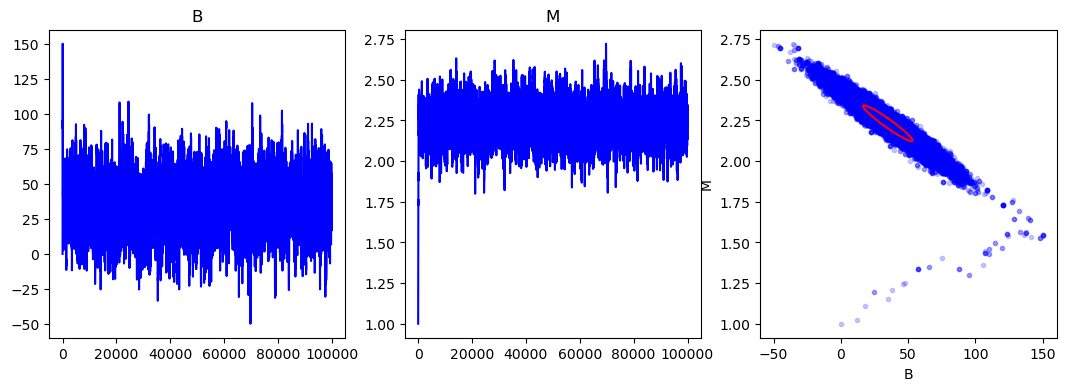

In [98]:
# Let's have a look at the resulting samples!
plt.figure(figsize=(13,4))
plt.subplot(1,3,1)
plt.plot(chain[:,0], 'b-')
plt.title('B')
plt.subplot(1,3,2)
plt.title('M')
plt.plot(chain[:,1], 'b-');
plt.subplot(1,3,3)
plt.plot(chain[:,0], chain[:,1], 'b.', alpha=0.2);
plt.xlabel('B')
plt.ylabel('M')
# Also plot up the elliptical constraint we got from the optimizer.
plt.plot(ellipse_b, ellipse_m, 'r-');

That looks way better!  Our samples are traversing the state space many times.

Let's also look at the resulting corner plot.

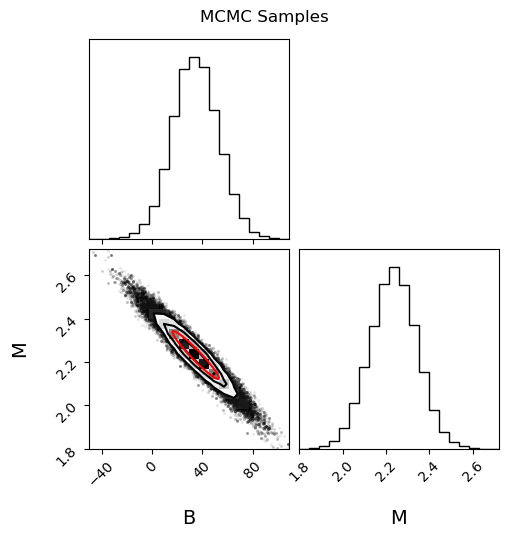

In [99]:
# Drop some "burn-in" samples
nburn = 1000
figure = corner.corner(chain[nburn:,:], labels=['B','M'], label_kwargs={"fontsize": 14})
plt.suptitle('MCMC Samples');
# also overplot our ML ellipse:
# extract the axes
axes = np.array(figure.axes)
axes[2].plot(ellipse_b, ellipse_m, 'r-');

That's looking considerably more smooth than previously -- our sampling of the parameter space is becoming more accurate!

<h3>Extensions: Please do ONE of the following:</h3>

(Please include the code, plots, text describing your answer below in this notebook.  If you're not doing (E.), please feel free to delete that part of the notebook.)

* A. <b>Extend the model from a linear model to a quadratic model.  That is, switch to $y_{\textrm{pred}} = b + m x + q x^2$.  You will need to write a new `log_likelihood_quadratic` function that expects three parameters, and set the initialization point to be in `(b,m,q)` space, and find a `q` step size that works well.  Run MCMC on that model, plot the results by randomly choosing some sample parameters and showing the model prediction along with the data point; create corner plots showing the distributions of the `b,m,q` parameters.  Next, focus on the `q` plot -- does it look like the model "needs" the quadratic term?  Is `q=0` within the distribution of plausible `q` values you find?</b>

* B. <b>What if the $\sigma$ values are estimated incorrectly?  (Eg, if your experimenter friends overlooked or mis-estimated some source of error in their data collection!)  Try increasing or decreasing the `yerr` values by a factor of 2 and re-make the plots.  How do the constraints on $B$ and $M$ change?  How does the visual quality of the fit change?  (That is: how many of the data points with their uncertainty bars intersect the fit line?  How many would you expect for the correct Gaussian distribution?  Is there a quantitative assessment of the fit quality you could use?)

* C. <b>We found jump sizes for $B$ and $M$ that led to okay acceptance ratios, but we are still taking jumps independently in the two variables, while we can clearly see that the variables are correlated.  Create a new `propose_func` that proposes jumps drawn from a Gaussian with appropriate covariance.  (hint, check out the `numpy.random.multivariate_normal` function, https://numpy.org/doc/1.16/reference/generated/numpy.random.multivariate_normal.html#numpy.random.multivariate_normal).  How could you estimate the covariance to use in this function?

* D. <b>We used "uninformative" priors on $B$ and $M$.  Try changing that -- for example, try placing a Gaussian (log-)prior on one of the parameters, and see how that affects your samplings.  How strong do you have to make the prior for it to have a significant effect on your results?  Next, try reparameterizing the problem, so that instead of the offset parameter $B$, your function takes a parameter $\beta$, and the offset is $\beta^2$.  Put a flat prior on $\beta$.  Do you get a different result for your distribution of MCMC samples for the offset?  Make histograms of the $B$ and $\beta^2$ values and compare them.

* E. <b>Continue going through the notebook below, looking at one way of handling outliers in data</b>

The End.

<h2>Handling outliers</h2>

At the beginning, we dropped some data points from our data set.  Here, we're going to see how we can modify our likelihood function to gain some immunity from outliers.

Outliers could be due to some glitch in the experimental equipment, or could be due to, say, including something in your sample that shouldn't be -- say, a supernova that isn't of Type 1a but some other type -- so that its behavior is not actually subject to the physical model we are proposing.

In [100]:
# Here, we re-define the x,y,yerr variables to include all data values
x    = alldata[:,0]
y    = alldata[:,1]
yerr = alldata[:,2]

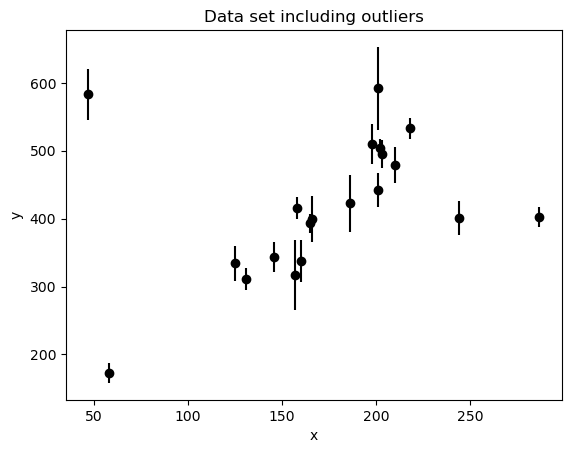

In [101]:
plt.errorbar(x, y, yerr=yerr, fmt='o', color='k');
plt.xlabel('x'); plt.ylabel('y')
plt.title('Data set including outliers');

Let's run our MCMC routine on this data set that includes outliers, and see what the results look like.

In [102]:
# initial B,M
initial_pos = [0., 1.0]
# proposal distribution: jump sizes for B,M
jump_sizes = [10., 0.05]
# Run MCMC!
chain,accept = mcmc(log_posterior_one, (x,y,yerr),
                    propose_gaussian, jump_sizes,
                    initial_pos, 5000)
print("Fraction of moves accepted:", accept)
chain.shape

Fraction of moves accepted: 0.3562


(5000, 2)

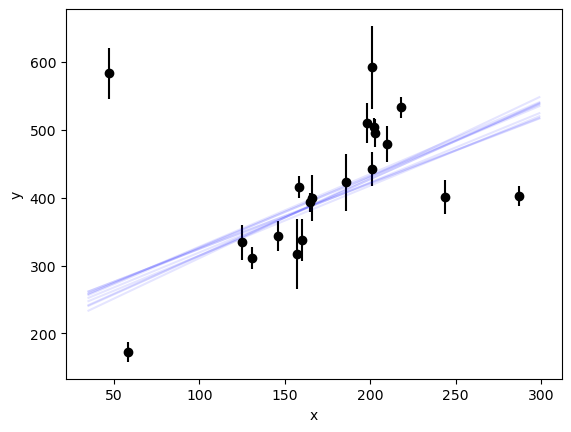

In [103]:
plt.errorbar(x, y, yerr=yerr, fmt='o', color='k');
plt.xlabel('x'); plt.ylabel('y');
# Let's plot the models for a few randomly drawn MCMC samples.
ax = plt.axis()
burn = 1000
I = np.random.randint(burn, high=len(chain), size=10)
xx = np.array(ax[:2])
for b,m in chain[I]:
    plt.plot(xx, b + m*xx, 'b-', alpha=0.1)

This doesn't look very good!

One thing to observe is that MCMC doesn't really care about the magnitude of your log-probabilities -- it doesn't know or care whether your data are *likely* given your model!  It will happily give you samples -- with nice tight constraints -- that are a terrible fit to your data.  This is true of nearly all model-fitting methods, and is a good reason to always *look at the data*!

<h3>Mixture model</h3>

The approach we're going to take for handling outliers is called a "mixture model".  We're going to say that our data points can be drawn from two different distributions.  The first distribution are the good data points that are actually generated by our model.  The second distribution are the outliers, and they are drawn from a broad model that spans the available data space.  There will be a "mixing fraction" that says what fraction of the data points are drawn from the "good" distribution.  (Note that we don't know which distribution each data point is drawn from!)

The idea here is that our Gaussian log-likelihood function is very sensitive to outliers -- if a data point is 10 sigma away from the model, MCMC is really going to want to move the model to be closer to that data point.  In the mixture model, a data point that are very far from the model will often be better explained by the outlier model, and when that happens, it is no longer affected by changes to the foreground model parameters, and so it no longer forces MCMC to move the model.


The likelihood for a mixture model can be written as

$p(y | \alpha, P\!A, P\!B) = \alpha \, p_A(y | P\!A) + (1 - \alpha) p_B(y | P\!B)$

where $\alpha$ i the "mixing fraction", model $A$ is the "foreground" or "good" model, with parameters $P\!A$, and model $B$ is the "background" or "outlier" model with parameters $P\!B$.

What should we use for our outlier model?

One simple approach is to take the range of your data and say that the 
"outlier" distribution has equal likelihood over that whole range.  So, we might give it a Uniform distribution over the range `0` to `800` (being a bit generous).  Usually it doesn't matter very much because the outlier model is competing against a terrible fit in the foreground model!

Below, I'm going to rename $\alpha$ to `p_good` -- the probability that a 
data point is good.  And we're going to infer that `p_good`.  If we had a more complicated background model, we could infer its parameters too.  For example, you could fit the background model as a (broad) Gaussian, and infer its mean and variance.

In [119]:
def log_likelihood_mixture(params, x, y, yerr, ylo, yhi):
    p_good, b, m = params
    y_pred = b + m * x

    # The "good" log-likelihood, same as before (but not summing the individual points)
    loglike_fg = np.log(1. / (np.sqrt(2. * np.pi) * yerr)) + -0.5*(y - y_pred)**2/yerr**2

    # The "bad" log-likelihood, which is uniform over the range [ylo, yhi].
    # (but here we don't actually check whether y is within that range, we always return a constant!)

    # FILL IN CODE HERE!
    # p_B(y | yhi,ylo) = 1/(yhi - ylo)
    # log(p_b) = ...
    loglike_bg = np.log(1/(yhi - ylo))

    # Now, we need to multiply the likelihoods by (p_good) and (1-p_good) and add them,
    # but they're in log space.  There is a special function for doing this, numpy's "logaddexp".
    if p_good == 0: pgood += 1e-10
    if p_good == 1: p_good -= 1e-10 
    loglike = np.logaddexp(np.log(p_good) + loglike_fg, np.log(1.-p_good) + loglike_bg)
    # Log-likelihood for the whole data set is the sum of individual log-likelihoods.
    return np.sum(loglike)

Let's look at what the *likelihood* for $y$ looks like for a single $x$ value.


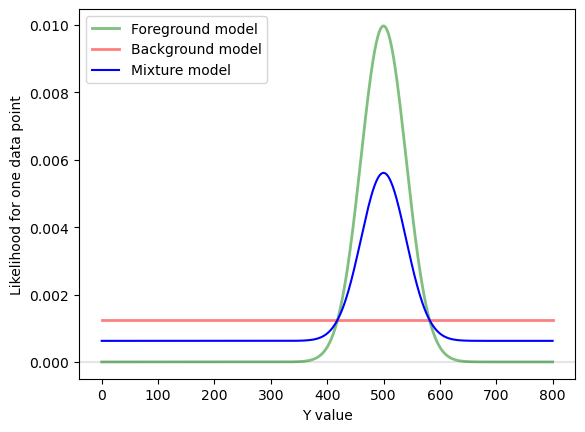

In [129]:
xi = 300
yei = 40
yy = np.linspace(0, 800, 500)
# Compute log-likelihoods for p_good = 1.0 (all foreground)
llA = [log_likelihood_mixture((1.0, 200., 1.), xi, yi, yei, 0., 800.) for yi in yy]
# Compute log-likelihoods for p_good ~= 0.0 (all background)
llB = [log_likelihood_mixture((1e-6, 200., 1.), xi, yi, yei, 0., 800.) for yi in yy]
plt.plot(yy, np.exp(llA), 'g-', alpha=0.5, lw=2, label='Foreground model')
plt.plot(yy, np.exp(llB), 'r-', alpha=0.5, lw=2, label='Background model')
ll = [log_likelihood_mixture((0.5, 200., 1.), xi, yi, yei, 0., 800.) for yi in yy]
plt.plot(yy, np.exp(ll), 'b-', label='Mixture model')
plt.xlabel('Y value')
plt.ylabel('Likelihood for one data point')
plt.legend()
plt.axhline(0., color='k', alpha=0.1);

In [113]:
# As before, here's our log-*posterior* function, as before, but expecting more parameters.
def log_posterior_mixture(params, args):
    (p_good, b, m) = params
    # Improper, flat priors on b,m
    logprior = 0.
    if p_good < 0 or p_good > 1:
        return -np.inf
    loglike = log_likelihood_mixture(params, *args)
    return loglike + logprior

In [136]:
initial_pos = [0.8, 50., 2.]
stepsizes = [0.01, 5., 0.05]
steps = 10000
ylo, yhi = 0., 800.
chain, faccept = mcmc(log_posterior_mixture, (x, y, yerr, ylo, yhi), propose_gaussian, stepsizes, initial_pos, steps)
print("Fraction of moves accepted:", accept)
chain.shape

Fraction of moves accepted: 0.3562


(10000, 3)

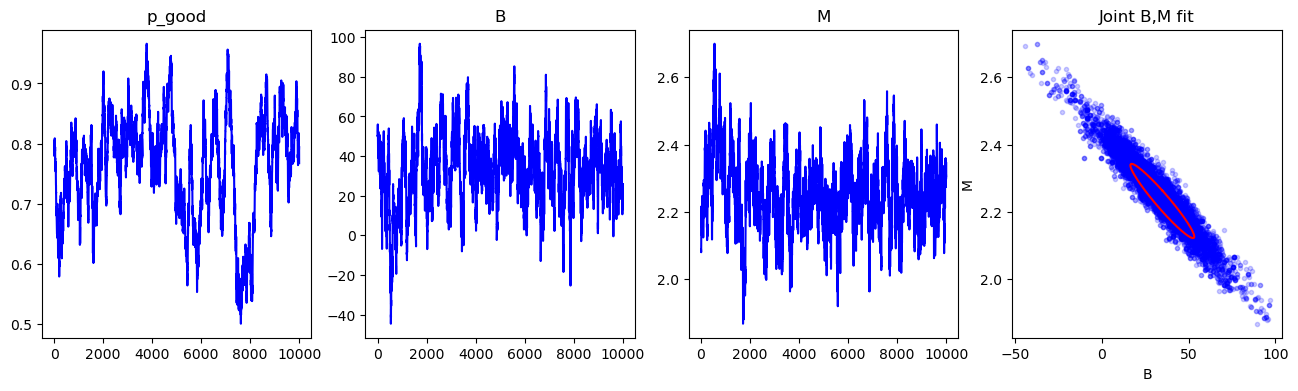

In [137]:
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.plot(chain[:,0], 'b-')
plt.title('p_good')
plt.subplot(1,4,2)
plt.title('B')
plt.plot(chain[:,1], 'b-');
plt.subplot(1,4,3)
plt.title('M')
plt.plot(chain[:,2], 'b-');
plt.subplot(1,4,4)
plt.plot(chain[:,1], chain[:,2], 'b.', alpha=0.2);
plt.title('Joint B,M fit')
plt.xlabel('B')
plt.ylabel('M')
# Also plot up the elliptical constraint we got from the optimizer.
plt.plot(ellipse_b, ellipse_m, 'r-');

Notice the values of `p_good` that the sampler finds -- 70--90%.  Does that seem reasonable given the number of outlier data points?


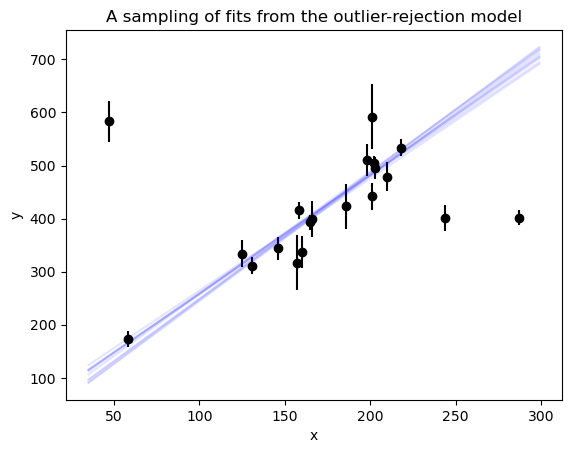

In [141]:
# Let's plot the models for a few randomly drawn MCMC samples.
plt.errorbar(x, y, yerr=yerr, fmt='o', color='k');
plt.xlabel('x'); plt.ylabel('y');
ax = plt.axis()
burn = 1000
I = np.random.randint(burn, high=len(chain), size=10)
xx = np.array(ax[:2])
for pgood,b,m in chain[I]:
    plt.plot(xx, b + m*xx, 'b-', alpha=0.1)
plt.title('A sampling of fits from the outlier-rejection model');

It works!  The model has managed to fit the good data without being thrown off by the outliers!

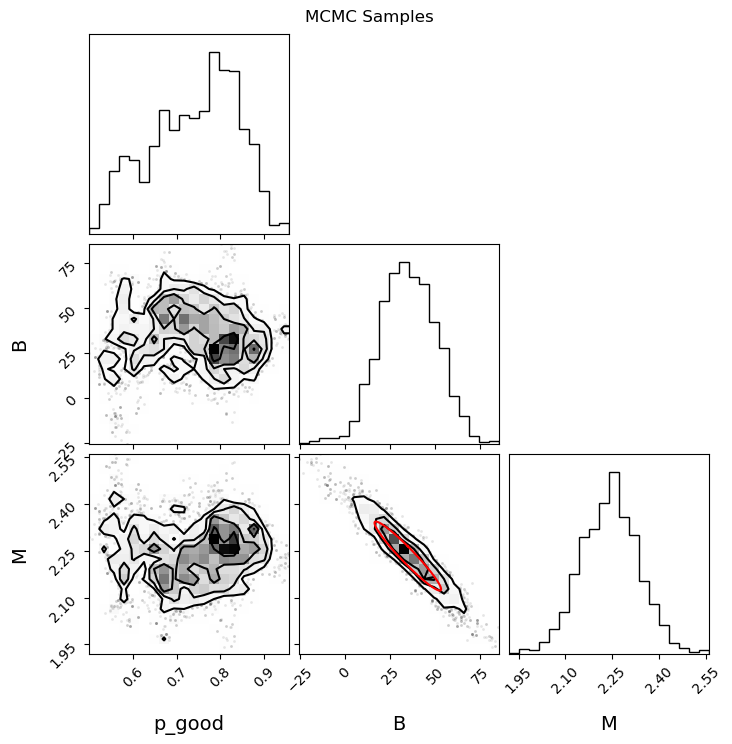

In [142]:
# Let's have a look at the corner plots
nburn = 5000
figure = corner.corner(chain[nburn:,:], labels=['p_good', 'B','M'], label_kwargs={"fontsize": 14})
plt.suptitle('MCMC Samples');
# also overplot our ML ellipse:
# extract the axes
axes = np.array(figure.axes)
axes[7].plot(ellipse_b, ellipse_m, 'r-');

That's interesting, it looks like the sampler spent some time at $B$,$M$ values quite far from the "core" of the distribution.

I think what is happening is that the fit is deciding that a different set of data points are "inliers" vs "outliers.

<b>Can you find initialization parameters that cause the MCMC algorithm to decide that a different set of points are good and the majority of the points are outliers?  Eg, try finding $B$ and $M$ so that the outlier point in the top-left corner in the $(x,y)$ plot is on the fit line.</b>

In [144]:
initial_pos = [0.8, 700, -2.]
stepsizes = [0.01, 5., 0.05]
steps = 10000
ylo, yhi = 0., 800.
chain, faccept = mcmc(log_posterior_mixture, (x, y, yerr, ylo, yhi), propose_gaussian, stepsizes, initial_pos, steps)
print("Fraction of moves accepted:", accept)
chain.shape

Fraction of moves accepted: 0.3562


(10000, 3)

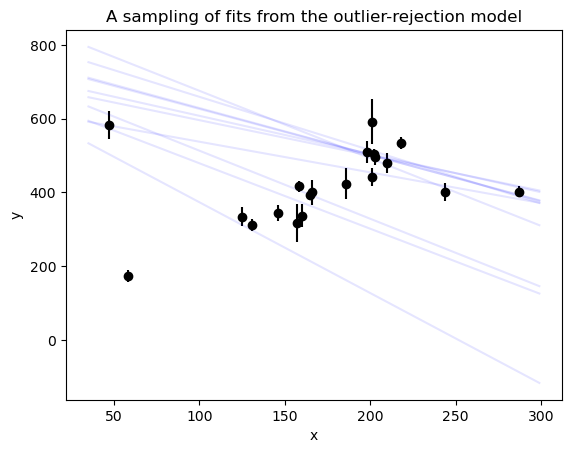

In [145]:
# Let's plot the models for a few randomly drawn MCMC samples.
plt.errorbar(x, y, yerr=yerr, fmt='o', color='k');
plt.xlabel('x'); plt.ylabel('y');
ax = plt.axis()
burn = 1000
I = np.random.randint(burn, high=len(chain), size=10)
xx = np.array(ax[:2])
for pgood,b,m in chain[I]:
    plt.plot(xx, b + m*xx, 'b-', alpha=0.1)
plt.title('A sampling of fits from the outlier-rejection model');

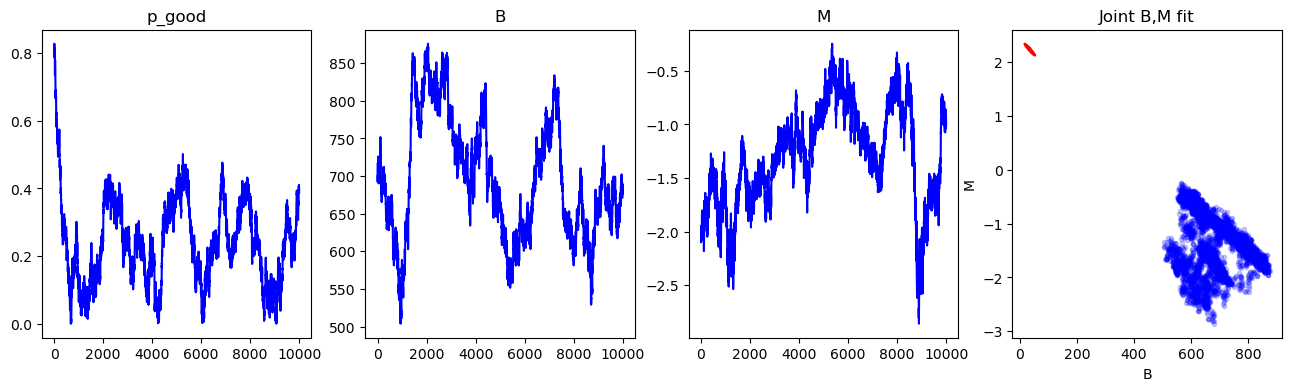

In [146]:
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.plot(chain[:,0], 'b-')
plt.title('p_good')
plt.subplot(1,4,2)
plt.title('B')
plt.plot(chain[:,1], 'b-');
plt.subplot(1,4,3)
plt.title('M')
plt.plot(chain[:,2], 'b-');
plt.subplot(1,4,4)
plt.plot(chain[:,1], chain[:,2], 'b.', alpha=0.2);
plt.title('Joint B,M fit')
plt.xlabel('B')
plt.ylabel('M')
# Also plot up the elliptical constraint we got from the optimizer.
plt.plot(ellipse_b, ellipse_m, 'r-');

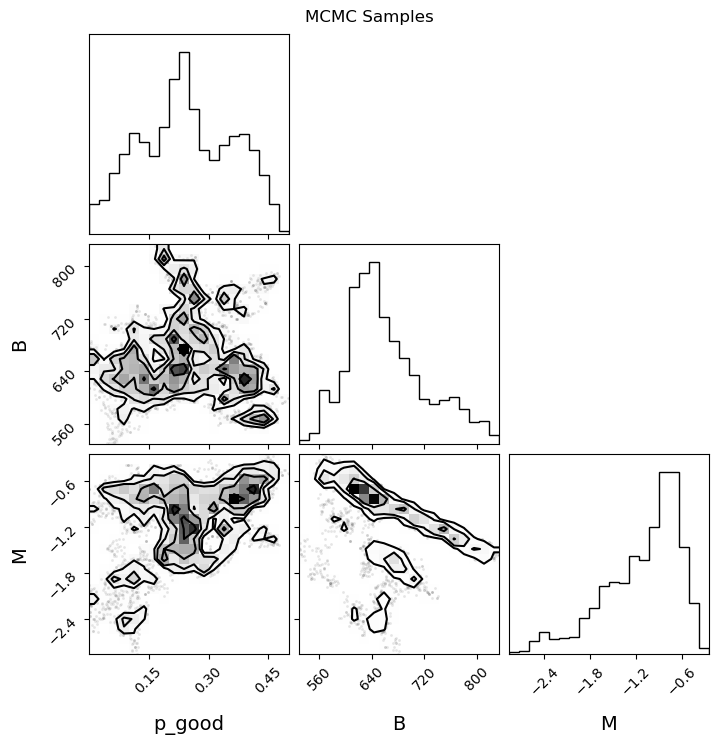

In [147]:
# Let's have a look at the corner plots
nburn = 5000
figure = corner.corner(chain[nburn:,:], labels=['p_good', 'B','M'], label_kwargs={"fontsize": 14})
plt.suptitle('MCMC Samples');
# also overplot our ML ellipse:
# extract the axes
axes = np.array(figure.axes)
axes[7].plot(ellipse_b, ellipse_m, 'r-');